# Land Cover Modelling with U-Net

This script purpose is to generate and train the land cover model. It will load the patches from the [preprocess.ipynb](./modelling.ipynb) script, split it into train and test sets, used to fit the model, assess the model, and visualize the difference between the actual test result and its prediction, and saved the model (for later used mayb


In [ ]:
import rasterio as rio
import os
import json
import pandas as pd
from PIL import ImageColor

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    Input,
    concatenate,
)
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from skimage.exposure import rescale_intensity
from rasterio.enums import Resampling
import rasterio.warp as warp

In [ ]:
# Location of data
lc_dir = "../../data/lc.json"
lc_image_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/LC_Image_v1.tif"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [3]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values                      label  values_normalize
0   #006400    2001     Primary dryland forest                 1
1   #228B22    2002   Secondary dryland forest                 2
2   #4B0082    2004    Primary mangrove forest                 3
3   #808000    2005       Primary swamp forest                 4
4   #32CD32    2006          Plantation forest                 5
5   #90EE90    2007                  Dry shrub                 6
6   #FF4500    2010                Estate crop                 7
7   #F08080    2012                 Settlement                 8
8   #D2B48C    2014                Bare ground                 9
9   #ADFF2F    3000        Savanna and grasses                10
10  #87CEFA    5001                 Open water                11
11  #6A5ACD   20041  Secondary mangrove forest                12
12  #6B8E23   20051     Secondary swamp forest                13
13  #66CDAA   20071                  Wet shrub                14
14  #FFD700   20091       Pure dry agriculture                15
15  #FFA500   20092      Mixed dry agriculture                16
16  #008080   20093                Paddy field                17
17  #E6E6FA   20094      Fish pond/aquaculture                18
18  #B22222   20121            Port or harbour                19
19  #C71585   20122       Transmigration areas                20
20  #A0522D   20141                     Mining                21
21  #7FFFD4   50011                      Swamp                22

In [ ]:
# load image sample
lc_values = os.listdir("result/images")
lc_values = list(map(lambda x: int(x.split("_")[0]), lc_values))
lc_values = np.unique(lc_values)
lc_values.sort()
lc_values

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 20, 22])

### Augmentation Function

While we have quite many samples, we need more diverse sample to make sure the model is actually learning instead of just remembering.

To achieve that, the sample/patches will be flipped and rotated and added to the rest of samples.


In [ ]:
# Function to augment and add more sample
def augment(array, list):
    flip = np.flip(array, 1)
    for arr in [array, flip]:
        for rot in [1, 2, 3]:
            list.append(np.rot90(arr, rot))

### Load the patches, train/test split, and augmentation

The loaded patches, either the landsat image and land cover label, will be split into train and test data using 4:1 ratio.

After split, all of the data will be augmented to increase sample size and to make the model learn better.


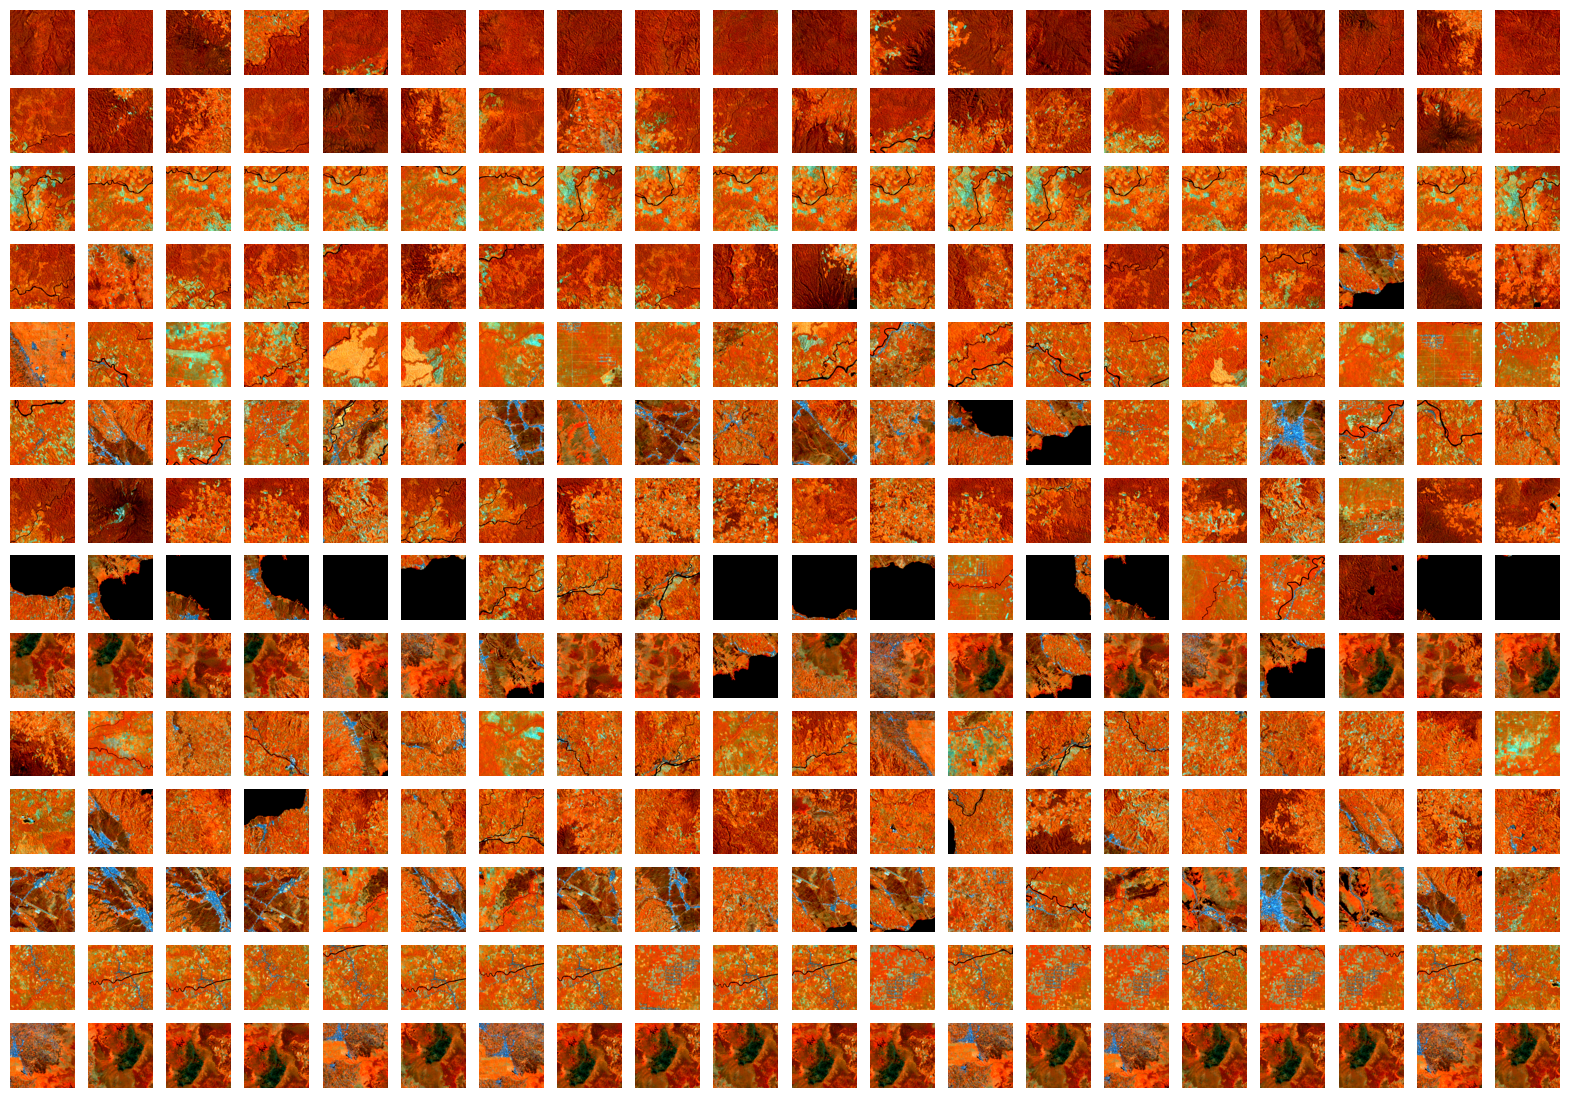

In [11]:
# Define image per land cover
image_per_lc = 20
index_train = int(8 / 10 * image_per_lc)

plt.figure(figsize=(image_per_lc, len(lc_values)))

# List of images
images_train = []
images_test = []

# Load image first
for x in range(0, len(lc_values)):
    lc = lc_values[x]
    images_list = os.listdir("result/images")
    images_list = list(filter(lambda x: int(x.split("_")[0]) == lc, images_list))

    for y in range(0, len(images_list)):
        dir = images_list[y]
        name = dir.split(".")[0]
        image_dir = f"result/images/{dir}"
        source = rio.open(image_dir)

        # Make it into a image shape to plot
        image = np.transpose(source.read(), (1, 2, 0))

        # Augment then add to the list
        augment(image, images_train if (y < index_train) else images_test)

        # Plot the image
        plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
        plt.imshow(image)
        plt.axis("off")

        source.close()

# Turn in into numpy array stacks
images_train = np.stack(images_train)
images_test = np.stack(images_test)

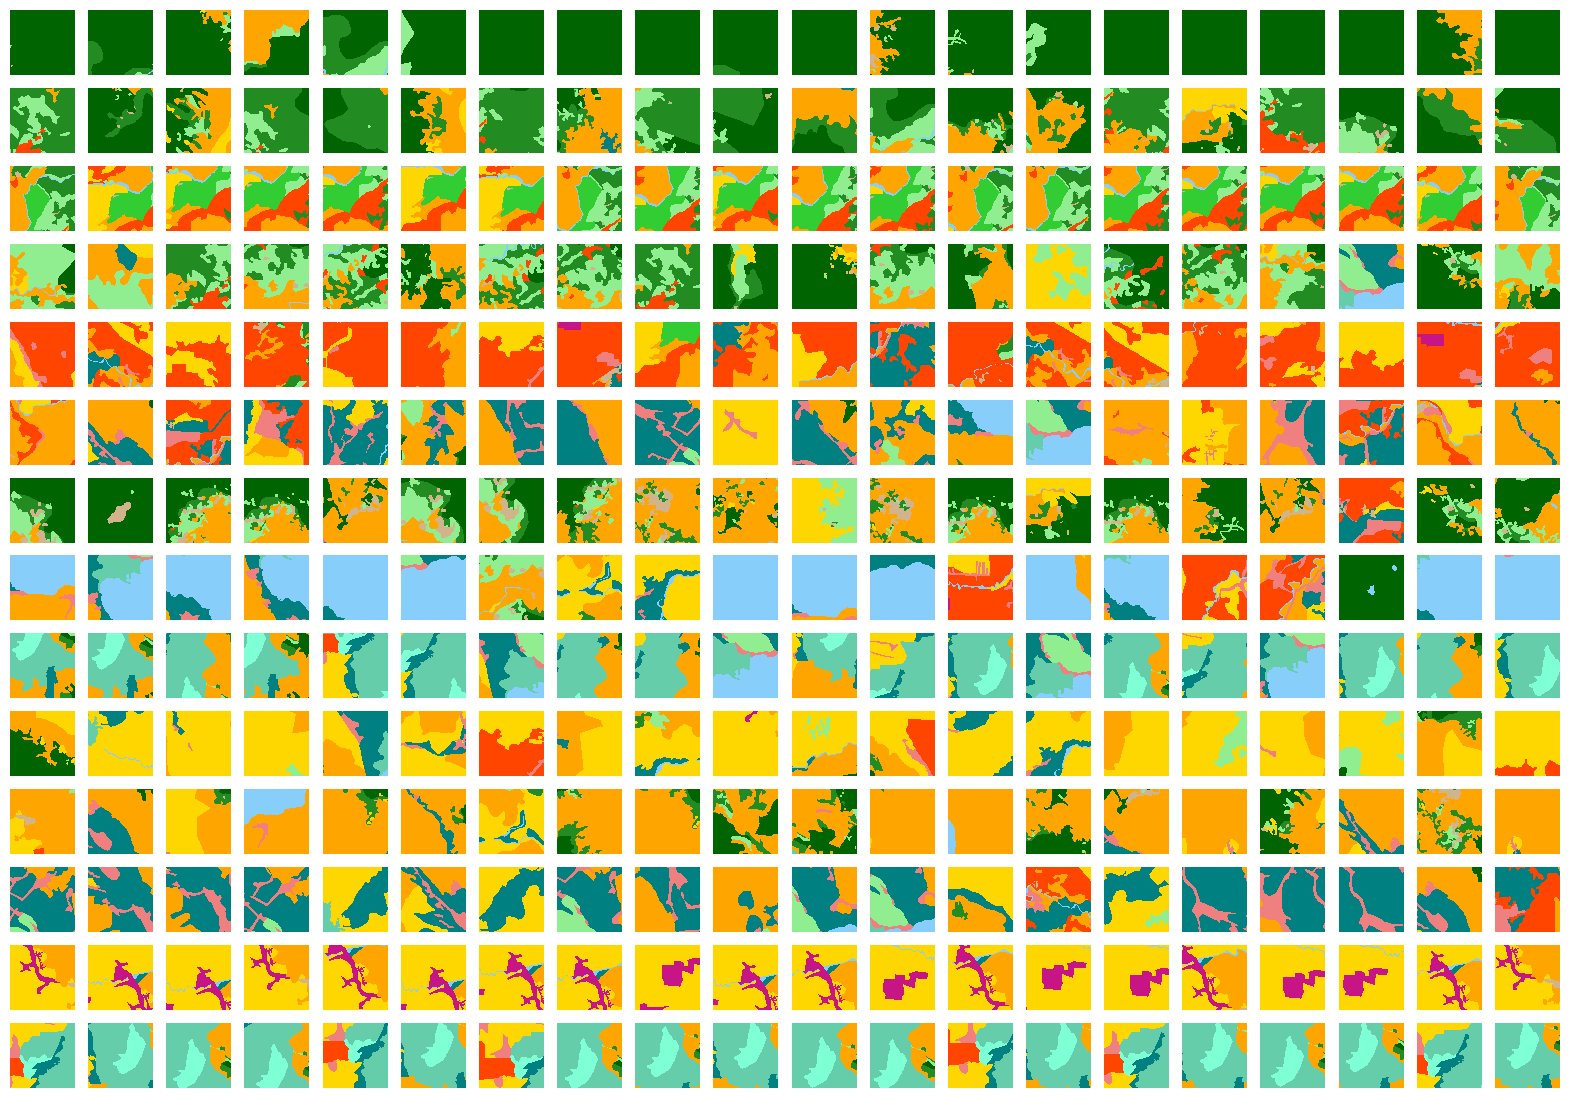

In [10]:
# Load lc first
plt.figure(figsize=(image_per_lc, len(lc_values)))

lcs_train = []
lcs_test = []

for x in range(0, len(lc_values)):
    lc = lc_values[x]
    images_list = os.listdir("result/lcs")
    images_list = list(filter(lambda x: int(x.split("_")[0]) == lc, images_list))

    for y in range(0, len(images_list)):
        dir = images_list[y]
        name = dir.split(".")[0]
        image_dir = f"result/lcs/{dir}"
        source = rio.open(image_dir)
        image = source.read()

        # Transposed the image into an image object
        transposed = np.transpose(image, (1, 2, 0))

        # Augment then add to the list
        augment(transposed, lcs_train if (y < index_train) else lcs_test)

        # Plot the land cover
        plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
        plt.imshow(image[0], cmap=cmap, interpolation="nearest", vmin=1, vmax=22)
        plt.axis("off")

        source.close()

lcs_train = np.stack(lcs_train)
lcs_test = np.stack(lcs_test)

In [ ]:
print(
    f"Train_predictors_shape: {images_train.shape}\nTrain_label_shape: {lcs_train.shape}\nTest_predictors_shape: {images_test.shape}\nTest_label_shape: {lcs_test.shape}"
)

Train_predictors_shape: (1344, 128, 128, 3)
Train_label_shape: (1344, 128, 128, 1)
Test_predictors_shape: (336, 128, 128, 3)
Test_label_shape: (336, 128, 128, 1)


In [15]:
# Make lcs data into categorical
# Keras model use different output data shape for category data
# Convert it using utility from keras to make into categorical shape
lcs_train_category = to_categorical(lcs_train)
lcs_test_category = to_categorical(lcs_test)

### Create U-Net Model

This script contain the function, parameter, and structure of the U-Net model to classify land cover from Landsat imagery.

You can change the neuron and kernel if you want to adjust how many layers or window where the model learn.

More layers mean bigger model and bigger kernel mean more generalized model.


In [ ]:
# Make keras model
input_shape = images_train.shape
input_shape = (input_shape[1], input_shape[2], input_shape[3])

neuron = 64
kernel = 3
kernel_t = 2
dropout = 0.2
strides = 2
pool = 2
padding = "same"#

input_layer = Input(input_shape)


def conv2_block(input, neuron, last=False):
    conv1 = Conv2D(neuron, kernel, activation="relu", padding=padding)(input)
    conv2 = Conv2D(neuron, kernel, activation="relu", padding=padding)(conv1)
    return conv2


def encode(input, neuron):
    conv1 = conv2_block(input, neuron)
    mp = MaxPooling2D(2)(conv1)
    dp = Dropout(dropout)(mp)
    return conv1, dp


def decode(input, conv, neuron):
    conv_t = Conv2DTranspose(
        neuron, kernel_t, strides, activation="relu", padding=padding
    )(input)
    concat = concatenate([conv_t, conv])
    conv2 = conv2_block(concat, neuron)
    dp = Dropout(dropout)(conv2)
    return dp


conv1, mp1 = encode(input_layer, neuron * 1)
conv2, mp2 = encode(mp1, neuron * 2)
conv3, mp3 = encode(mp2, neuron * 4)
conv4, mp4 = encode(mp3, neuron * 8)

transition = conv2_block(mp4, neuron * 16)

uncov1 = decode(transition, conv4, neuron * 8)
uncov2 = decode(uncov1, conv3, neuron * 4)
uncov3 = decode(uncov2, conv2, neuron * 2)
uncov4 = decode(uncov3, conv1, neuron * 1)

output = Conv2D(lcs_train_category.shape[3], 1, padding=padding, activation="softmax")(
    uncov4
)

model = Model(input_layer, output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_9[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ dropout_10[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 8, 8, 512) │          0 │ max_pooling2d_7[

 Total params: 31,033,175 (118.38 MB)

 Trainable params: 31,033,175 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Complie and Train Model

Created model need to be complied and trained using patches we made before.

You adjust how many epochs that you train the model, learning rate in the optimizers, batch size (how many patches trained at one time), and validation split (how many sample are used for validation).

After the training is done, you will asses it.


In [ ]:
# Compile and build the model
model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

callbacks = [EarlyStopping(patience=5, monitor="categorical_accuracy")]

result = model.fit(
    x=images_train,
    y=lcs_train_category,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.1310 - loss: 2.9512 - val_categorical_accuracy: 0.1123 - val_loss: 2.6277
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - categorical_accuracy: 0.2180 - loss: 2.5155 - val_categorical_accuracy: 0.1183 - val_loss: 2.5915
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - categorical_accuracy: 0.3066 - loss: 2.1867 - val_categorical_accuracy: 0.1092 - val_loss: 2.3757
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - categorical_accuracy: 0.4187 - loss: 1.8452 - val_categorical_accuracy: 0.0984 - val_loss: 2.4517
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - categorical_accuracy: 0.4064 - loss: 1.7641 - val_categorical_accuracy: 0.1074 - val_loss: 2.3336
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - categorical_accuracy: 0.4211 - loss: 1.7084 - val_categorical_accuracy: 0.0994 - val_loss: 2.2046
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - categorical_accuracy: 0.4644 - loss: 1.5

    categorical_accuracy      loss  val_categorical_accuracy  val_loss
0               0.176316  2.780626                  0.112344  2.627701
1               0.228048  2.464843                  0.118299  2.591520
2               0.335556  2.084491                  0.109233  2.375710
3               0.396341  1.849861                  0.098393  2.451689
4               0.405688  1.767365                  0.107402  2.333588
..                   ...       ...                       ...       ...
68              0.881718  0.376749                  0.472819  1.493791
69              0.816896  0.567238                  0.755875  1.117426
70              0.904383  0.284063                  0.777122  1.141150
71              0.912343  0.256551                  0.805412  0.992165
72              0.927040  0.208671                  0.802365  1.077818

[73 rows x 4 columns]


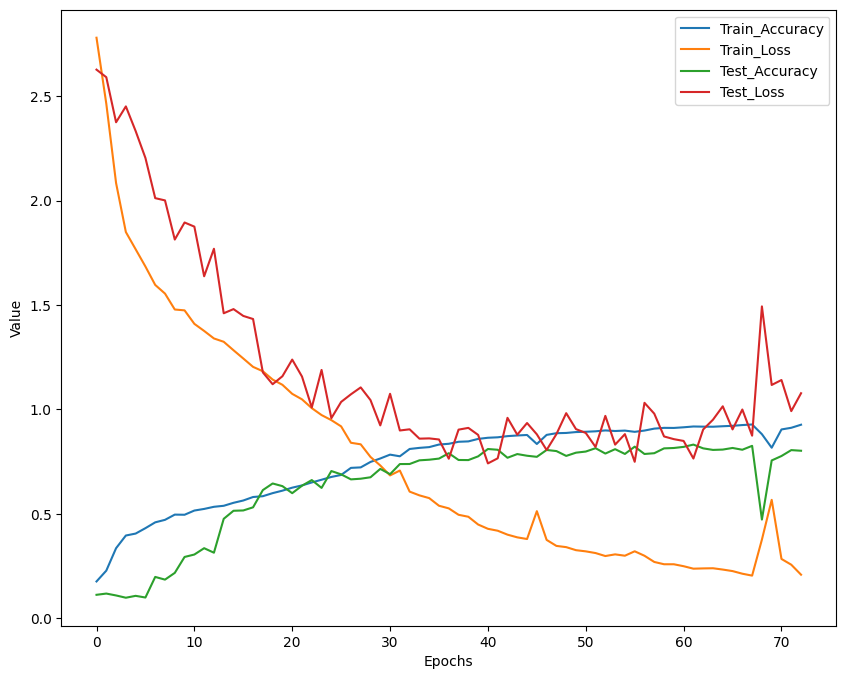

In [ ]:
# Show history
history = pd.DataFrame(result.history)
print(history)

plt.figure(figsize=(10, 8))
plt.plot(
    range(len(history["categorical_accuracy"].values.tolist())),
    history["categorical_accuracy"].values.tolist(),
    label="Train_Accuracy",
)
plt.plot(
    range(len(history["loss"].values.tolist())),
    history["loss"].values.tolist(),
    label="Train_Loss",
)
plt.plot(
    range(len(history["val_categorical_accuracy"].values.tolist())),
    history["val_categorical_accuracy"].values.tolist(),
    label="Test_Accuracy",
)
plt.plot(
    range(len(history["val_loss"].values.tolist())),
    history["val_loss"].values.tolist(),
    label="Test_Loss",
)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

### Assess the Model Performance with Test Data

After the model is trained, then it will be apply to the test data.

The applied test data then compared to the true land cover label patches of the test data.

The assessment is done using classification report and confusion matrix


In [25]:
# Predict test data
prediction = np.argmax(model.predict(images_test), 3).flatten()
label = lcs_test.flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 682ms/step


              precision    recall  f1-score   support

           1       0.77      0.86      0.81    664320
           2       0.39      0.47      0.43    320184
           5       0.91      0.95      0.93     91104
           6       0.60      0.38      0.46    272628
           7       0.80      0.58      0.67    347316
           8       0.74      0.58      0.65    129420
           9       0.44      0.16      0.23     40878
          11       0.97      0.95      0.96    397632
          14       0.92      0.81      0.86    479244
          15       0.74      0.70      0.72    907158
          16       0.67      0.80      0.73   1178262
          17       0.85      0.85      0.85    506064
          20       0.80      0.77      0.78     67614
          22       0.92      0.93      0.93    103200

    accuracy                           0.75   5505024
   macro avg       0.75      0.70      0.72   5505024
weighted avg       0.75      0.75      0.75   5505024



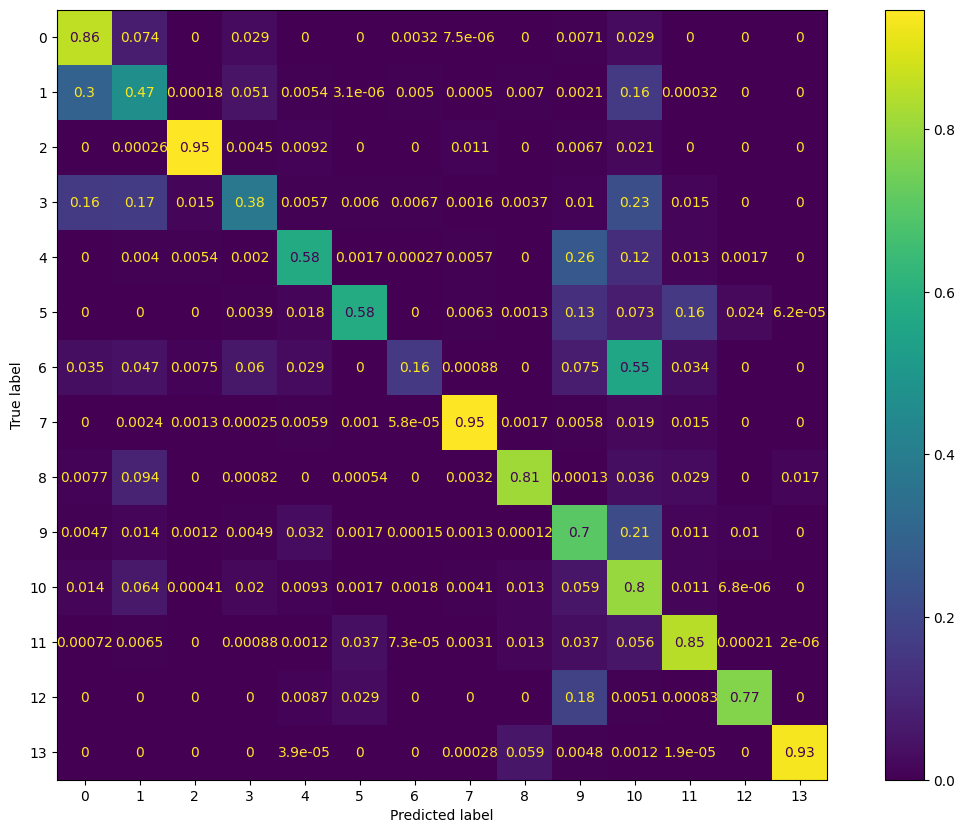

In [ ]:
# Confusion matrix
cm = confusion_matrix(label, prediction, normalize="true")
fig, ax = plt.subplots(figsize=(15, 10))
cm = ConfusionMatrixDisplay(cm)
cm.plot(ax=ax)

# Classification report
print(classification_report(label, prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

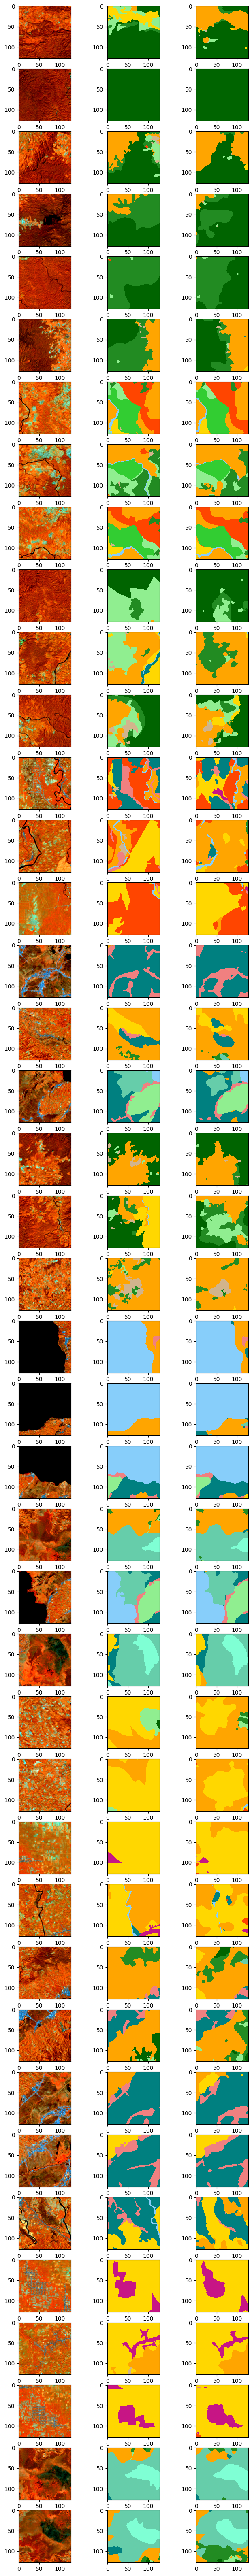

In [ ]:
image_non_augment_size = int(len(images_test) / 8)

plt.figure(figsize=(8, image_non_augment_size * 2))

# Apply to classified image of the image
for x in range(0, image_non_augment_size - 1):
    index = x * 8

    image = images_test[index : (index + 1)]
    pred = model.predict(image)
    pred = np.argmax(pred, 3)[0]

    plt.subplot(image_non_augment_size, 3, x * 3 + 1)
    plt.imshow(image[0])

    plt.subplot(image_non_augment_size, 3, x * 3 + 2)
    plt.imshow(lcs_test[index], cmap=cmap, interpolation="nearest", vmin=1, vmax=22)

    plt.subplot(image_non_augment_size, 3, x * 3 + 3)
    plt.imshow(pred, cmap=cmap, interpolation="nearest", vmin=1, vmax=22)

In [ ]:
# Save model
model.save("result/dl_unet_landcover_model_v1.keras")

## Apply to the Whole Image

Here we apply the model to the whole image the compared it side by side with the satellite imagery and true label.

We also will saved it as geotiff to open in other sofware


In [ ]:
# Try to run to the whole image
source = rio.open(
    "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"
)

# Read as 1x1 ratio to make it fit to the model input shape
landsat_image = source.read(out_shape=(2560, 2560)) / 1e4
landsat_image.shape

(8, 2560, 2560)

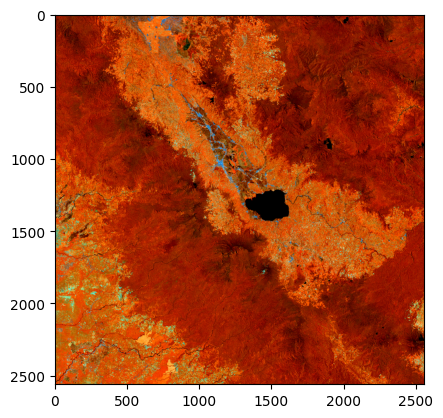

In [ ]:
# Composite
# Create a composite
composite = np.dstack(
    [
        rescale_intensity(landsat_image[4], in_range=(0.125, 0.4), out_range=(0, 1)),
        rescale_intensity(landsat_image[5], in_range=(0.1, 0.3), out_range=(0, 1)),
        rescale_intensity(landsat_image[6], in_range=(0.075, 0.2), out_range=(0, 1)),
    ]
)

# Visualize composite
plt.imshow(composite)

In [98]:
# Prepare input
input_image = np.stack([np.transpose(composite, (0, 1, 2))])

# Apply model
prediction_image = model.predict(input_image)
prediction_image = np.argmax(prediction_image, 3)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


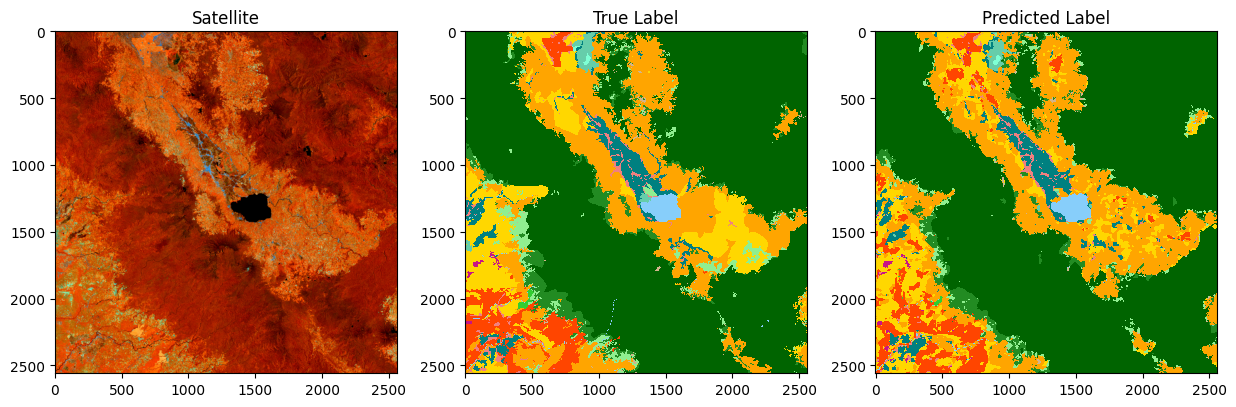

In [ ]:
plt.figure(figsize=(15, 5))

# Show composite
plt.subplot(1, 3, 1)
plt.title("Satellite")
plt.imshow(composite)

# Show the real land cover label
# Load land cover image
lc_source = rio.open(lc_image_dir)
lc_image = lc_source.read(out_shape=(2560, 2560))[0]
# Remap LC image data
for x in range(0, len(lc_df)):
    lc_dict = lc_df.loc[x]
    lc_image[lc_image == lc_dict["values"]] = lc_dict["values_normalize"]
plt.subplot(1, 3, 2)
plt.title("True Label")
plt.imshow(lc_image, cmap=cmap, interpolation="nearest", vmin=1, vmax=22)

# Showed it compared to other image
plt.subplot(1, 3, 3)
plt.title("Predicted Label")
plt.imshow(prediction_image, cmap=cmap, vmin=1, vmax=22, interpolation="nearest")

In [ ]:
# Save the prediction image
output = rio.open(
    "result/LC_Prediction_v1.tif",
    "w",
    "COG",
    width=source.width,
    height=source.height,
    count=1,
    crs=source.crs,
    transform=source.transform,
    nodata=0,
    dtype="uint8",
    compress="lzw",
    resampling=Resampling.nearest,
)
output.write(prediction_image, 1)
output.write_colormap(1, dict_palette)
output.close()